In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import numpy.random
import yfinance as yf
import pandas as pd
from scipy.optimize import minimize
import matplotlib.animation as animation

## Sample Figures

Text(0, 0.5, 'Closing Price ($)')

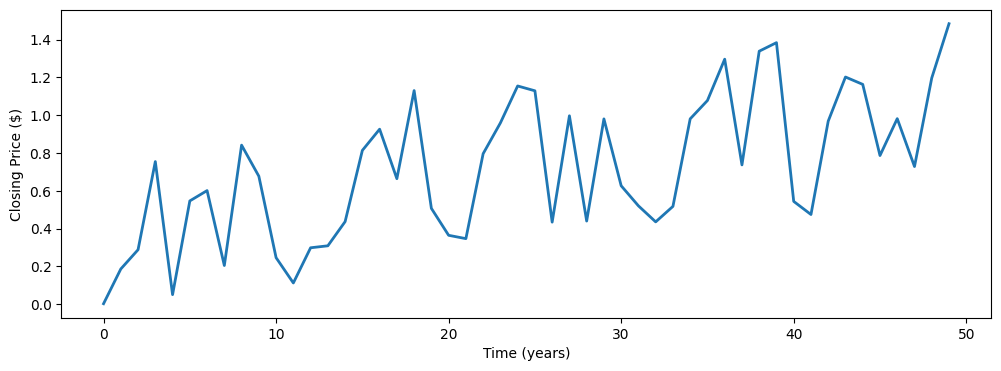

In [ ]:
rand_chart = [np.random.random()+i/100 for i in range(50)]

# Plot closing prices
plt.figure(figsize=(12, 4))
plt.plot(rand_chart, linewidth=2)

# set the plot labels
plt.xlabel("Time (years)")
plt.ylabel("Closing Price ($)")

## Animating Monte Carlo

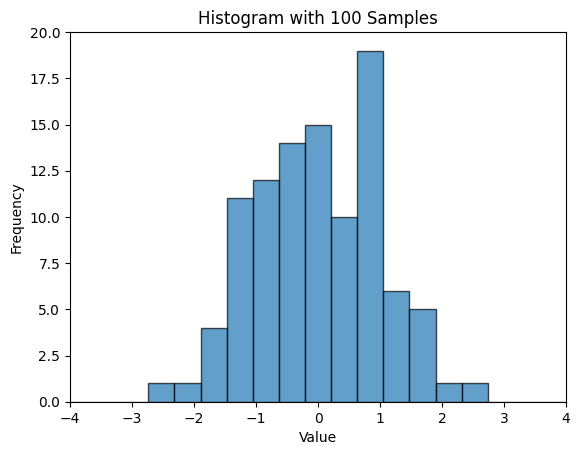

In [3]:
# Generate 100 samples from a normal distribution
samples = np.random.normal(loc=0, scale=1, size=100)

fig, ax = plt.subplots()

# Set up histogram parameters
bins = np.linspace(-4, 4, 20)  # fixed bin edges

ax.set_xlim(-4, 4)
ax.set_ylim(0, 20)
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")

# Update function for animation
def update(frame):
    ax.clear()
    ax.hist(samples[:frame+1], bins=bins, edgecolor='black', alpha=0.7)
    ax.set_xlim(-4, 4)
    ax.set_ylim(0, 20)
    ax.set_title(f"Histogram with {frame+1} Samples")
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

ani = animation.FuncAnimation(fig, update, frames=len(samples), interval=200, repeat=False)

# Save as GIF (requires pillow installed: pip install pillow)
ani.save("histogram.gif", writer="pillow")

plt.show()

## Portfolio Simulation

In [15]:
A = np.array([0.03, 0.09])
B = np.array([0.05, 0.1])
C = np.array([0.08, 0.2])

assets = np.array([A,B,C])
actual_weights = np.array([[0.16],  # 0.3
                           [0.56],  # 0.5
                           [0.28]]) # 0.2
actual_weights_transposed = actual_weights.T # transposed for matrix mul later

Expected Portfolio Return: 5.33%
Portfolio Std Dev: 2.68%
95% Value-at-Risk: 7.42%


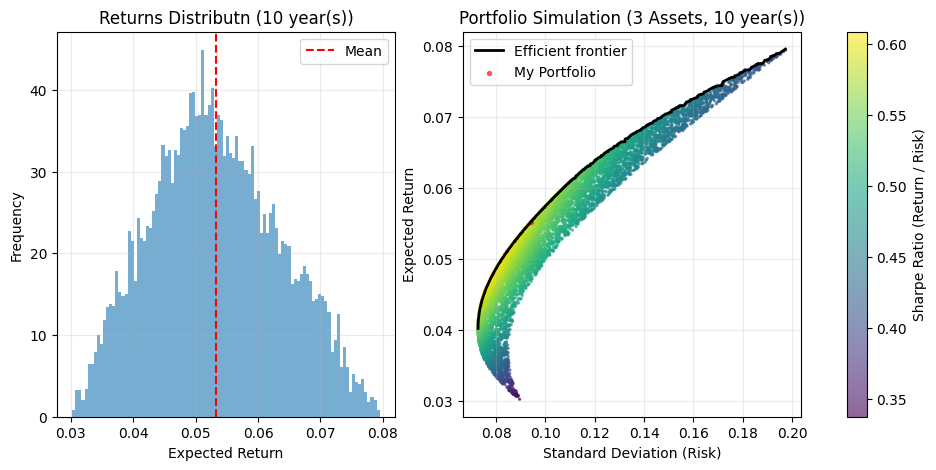

In [ ]:
# --- Inputs ---
# Expected annual returns for the 3 assets
annual_returns = np.array([row[0] for row in assets])  
annual_returns_actual_weights = sum(np.array([assets[i][0]*actual_weights[i][0] for i in range(len(assets))])) # for actual_weights

# Standard deviations (volatility)
sigmas = np.array([row[1] for row in assets])  

# Correlation matrix (assume some correlations here)
corr_matrix = np.array([
    [1.0, 0.2, 0.1],
    [0.2, 1.0, 0.3],
    [0.1, 0.3, 1.0]
])

# Covariance matrix
cov_matrix = np.outer(sigmas, sigmas) * corr_matrix 

# --- Monte Carlo parameters ---
n_sims = 10_000
time_horizon = 10  # years

# Random portfolio weights (summing to 1)
weights = np.random.dirichlet(np.ones(3), size=n_sims) 

# --- Simulation ---
# Generate correlated random returns
rand = np.random.multivariate_normal(annual_returns, cov_matrix, n_sims)

# Portfolio means and std devs
port_means = weights @ annual_returns   # (50000,)
port_stds = np.sqrt(np.sum(weights @ cov_matrix * weights, axis=1))

port_stds_actual_weights = np.sqrt(np.sum(actual_weights_transposed @ cov_matrix * actual_weights_transposed, axis=1))

# --- Results ---
mean_return = np.mean(port_means)
std_return = np.std(port_stds)
var_95 = np.percentile(port_stds, 5)  # 5th percentile Value-at-Risk

print(f"Expected Portfolio Return: {mean_return:.2%}")
print(f"Portfolio Std Dev: {std_return:.2%}")
print(f"95% Value-at-Risk: {var_95:.2%}")

# --- Efficient Frontier ---
# Sort by risk (std dev)
sorted_indices = np.argsort(port_stds)
sorted_stds = port_stds[sorted_indices]
sorted_means = port_means[sorted_indices]

# Keep only the **max return for each increasing risk** (upper envelope)
efficient_stds = []
efficient_means = []
current_max = -np.inf

for s, m in zip(sorted_stds, sorted_means):
    if m > current_max:
        efficient_stds.append(s)
        efficient_means.append(m)
        current_max = m

# --- Plotting ---
fig, ax = plt.subplots(figsize=(12,5), nrows=1, ncols=2)

ax[0].hist(port_means, bins=100, density=True, alpha=0.6)
ax[0].axvline(mean_return, color='red', linestyle='--', label='Mean')
ax[0].set_xlabel("Expected Return")
ax[0].set_ylabel("Frequency")
ax[0].set_title(f"Returns Distributn ({time_horizon} year(s))")

sc = ax[1].scatter(port_stds, port_means, c=port_means/port_stds, cmap='viridis', s=2, alpha=0.6, label="")
ax[1].set_xlabel("Standard Deviation (Risk)")
ax[1].set_ylabel("Expected Return")
ax[1].set_title(f"Portfolio Simulation ({len(assets)} Assets, {time_horizon} year(s))")

# Efficient frontier line
ax[1].plot(efficient_stds, efficient_means, color='k', linewidth=2, label='Efficient frontier')

# Current Portfolio with actual weights
ax[1].scatter(port_stds_actual_weights, annual_returns_actual_weights, color='red', s=8, alpha=0.6, label='My Portfolio')

# Colorbar
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("Sharpe Ratio (Return / Risk)")

for i in range(ax.shape[0]):
    ax[i].grid(alpha=0.25)
    ax[i].legend()

In [ ]:
def min_var_portfolio(exp_returns, cov_matrix, target_return):
    n = len(exp_returns)
    exp_returns = np.array(exp_returns)
    
    # --- Objective function (portfolio variance) ---
    def portfolio_variance(weights):
        return weights.T @ cov_matrix @ weights
    
    # --- Constraints ---
    constraints = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # weights sum to 1
        {'type': 'eq', 'fun': lambda w: w @ exp_returns - target_return}  # target return
    )
    
    # --- Bounds (weights between 0 and 1, long-only) ---
    bounds = tuple((0,1) for _ in range(n))
    
    # --- Initial guess (equal weights) ---
    w0 = np.ones(n) / n
    
    # --- Solve optimization problem ---
    result = minimize(portfolio_variance, w0, method='SLSQP', bounds=bounds, constraints=constraints)
    
    if result.success:
        return result.x  # optimal weights
    else:
        raise ValueError("Optimization did not converge")

# Example usage:
target_return = 0.055 # e.g. 12% annual target return
optimal_weights = min_var_portfolio(annual_returns, cov_matrix, target_return)


print("\nOptimal Weights for Target Return:")
for ticker, weight in zip(['A', 'B', 'C'], optimal_weights):
    print(f"{ticker}: {weight:.2%}")

annual_returns_actual_weights = optimal_weights



Optimal Weights for Target Return:
A: 16.28%
B: 56.20%
C: 27.52%
